In [4569]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4570]:
file_version = 14

In [4571]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-1,    # 0.01
    'BATCH_SIZE':256,
    'SEED':42,
    'log_turn': 1,
    'CUT': 0.01,     # drop column correlation cut line
    'T_Thresh': 0.5,     # Teacher model train Threshhold 최초 0.35
    'S_Thresh': 0.5,     # Student model train Threshold 최초 0.35
    'reduct' : 'mean',      # sum, mean
    'drop_rate': 0.2,
    'skew_cut':1
    
}

In [4572]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [4573]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

## 결측치 처리

<AxesSubplot:>

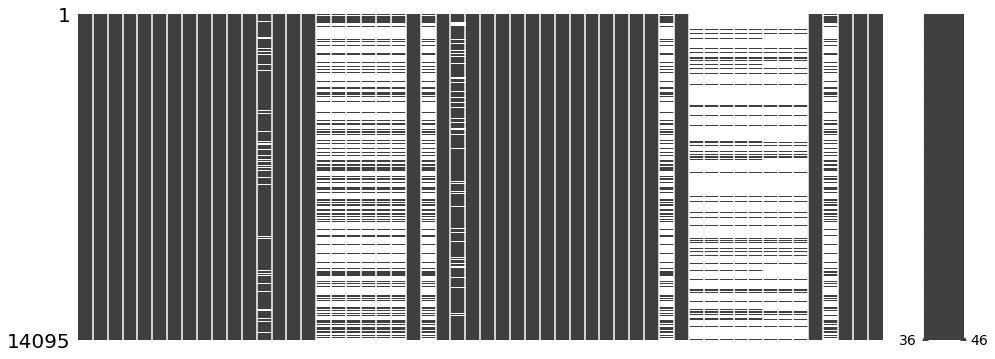

In [4574]:
import missingno as msno
msno.matrix(train, figsize=(16,6))

In [4575]:
train.describe(include="all")

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
count,14095,14095,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,...,2316.000000,2316.000000,2118.000000,2118.000000,2118.000000,14095.000000,3724.000000,14095.000000,14095.000000,14095.000000
unique,14095,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,TRAIN_00000,COMPONENT3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,7050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,3146.082937,2013.652501,7.600568,387.416885,0.025825,12.707698,64.026179,0.692799,...,29.870898,56.063472,239.938149,5488.693107,19415.597262,0.050656,13.576230,109.355815,588.646825,0.085349
std,NaN,NaN,4216.089809,3.964758,11.681628,550.016073,0.171926,86.968000,102.876871,2.905491,...,97.459625,184.332678,685.053457,15474.146283,40145.311444,0.475438,1.073718,49.612379,531.743393,0.279411
min,NaN,NaN,1000.000000,2007.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.000000,154.000000,0.000000,5.200000,2.900000,0.000000,0.000000
25%,NaN,NaN,1655.000000,2010.000000,3.000000,200.000000,0.000000,1.000000,3.000000,0.000000,...,3.000000,5.000000,22.000000,636.750000,5409.250000,0.000000,12.900000,71.800000,37.000000,0.000000
50%,NaN,NaN,2227.000000,2014.000000,5.000000,200.000000,0.000000,2.000000,11.000000,0.000000,...,7.000000,13.000000,57.000000,1753.000000,12691.500000,0.000000,13.500000,111.300000,520.000000,0.000000
75%,NaN,NaN,3797.000000,2017.000000,8.000000,410.000000,0.000000,4.000000,110.000000,0.000000,...,23.000000,39.250000,189.000000,5517.750000,24535.750000,0.000000,14.200000,137.200000,1119.000000,0.000000


In [4576]:
# 널값 칼럼값을 무엇으로 보간할까?
null_columns = []
for col in train.columns.tolist():
    if train[col].isna().any():
        null_columns.append(col)
        print(f"컬럼명: {col}, 널값수: {train[col].isna().sum():,}, 평균: {np.round(train[col].mean(),2)}, 중위수: {train[col].median()}, 최빈값: {train[col].mode().values[0]}")
    else:
        pass   
# null_columns

컬럼명: CD, 널값수: 1,394, 평균: 0.02, 중위수: 0.0, 최빈값: 0.0
컬럼명: FH2O, 널값수: 10,205, 평균: 15.24, 중위수: 13.0, 최빈값: 14.0
컬럼명: FNOX, 널값수: 10,205, 평균: 7.14, 중위수: 7.0, 최빈값: 6.0
컬럼명: FOPTIMETHGLY, 널값수: 10,205, 평균: 0.53, 중위수: 0.0, 최빈값: 0.0
컬럼명: FOXID, 널값수: 10,205, 평균: 12.5, 중위수: 12.0, 최빈값: 11.0
컬럼명: FSO4, 널값수: 10,205, 평균: 20.28, 중위수: 20.0, 최빈값: 20.0
컬럼명: FTBN, 널값수: 10,205, 평균: 8.78, 중위수: 8.7, 최빈값: 8.2
컬럼명: FUEL, 널값수: 10,205, 평균: 0.19, 중위수: 0.0, 최빈값: 0.0
컬럼명: K, 널값수: 2,299, 평균: 3.61, 중위수: 2.0, 최빈값: 0.0
컬럼명: SOOTPERCENTAGE, 널값수: 10,205, 평균: 0.61, 중위수: 0.4, 최빈값: 0.2
컬럼명: U100, 널값수: 11,779, 평균: 0.17, 중위수: 0.0, 최빈값: 0.0
컬럼명: U75, 널값수: 11,779, 평균: 0.42, 중위수: 0.0, 최빈값: 0.0
컬럼명: U50, 널값수: 11,779, 평균: 6.19, 중위수: 1.0, 최빈값: 0.0
컬럼명: U25, 널값수: 11,779, 평균: 29.87, 중위수: 7.0, 최빈값: 1.0
컬럼명: U20, 널값수: 11,779, 평균: 56.06, 중위수: 13.0, 최빈값: 4.0
컬럼명: U14, 널값수: 11,977, 평균: 239.94, 중위수: 57.0, 최빈값: 14.0
컬럼명: U6, 널값수: 11,977, 평균: 5488.69, 중위수: 1753.0, 최빈값: 300.0
컬럼명: U4, 널값수: 11,977, 평균: 19415.6, 중위수: 12691.5, 최빈값: 6789.0
컬럼명: V100,

In [4577]:
train[null_columns].describe(include="all")

,CD,FH2O,FNOX,FOPTIMETHGLY,FOXID,FSO4,FTBN,FUEL,K,SOOTPERCENTAGE,U100,U75,U50,U25,U20,U14,U6,U4,V100
count,12701.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,11796.000000,3890.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2118.000000,2118.000000,2118.000000,3724.000000
mean,0.015589,15.242159,7.138303,0.532905,12.495373,20.284319,8.783239,0.185347,3.611224,0.609254,0.173575,0.417098,6.185233,29.870898,56.063472,239.938149,5488.693107,19415.597262,13.576230
std,0.209407,17.591679,1.860775,0.621937,3.439535,3.234296,1.339355,0.899253,15.630404,0.652382,0.878892,1.626333,36.639482,97.459625,184.332678,685.053457,15474.146283,40145.311444,1.073718
min,0.000000,6.000000,3.000000,0.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,154.000000,5.200000
25%,0.000000,11.000000,6.000000,0.000000,10.000000,18.000000,8.100000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,3.000000,5.000000,22.000000,636.750000,5409.250000,12.900000
50%,0.000000,13.000000,7.000000,0.000000,12.000000,20.000000,8.700000,0.000000,2.000000,0.400000,0.000000,0.000000,1.000000,7.000000,13.000000,57.000000,1753.000000,12691.500000,13.500000
75%,0.000000,15.000000,8.000000,1.000000,14.750000,22.000000,9.600000,0.000000,3.000000,0.800000,0.000000,0.000000,3.000000,23.000000,39.250000,189.000000,5517.750000,24535.750000,14.200000
max,18.000000,320.000000,38.000000,13.000000,68.000000,68.000000,27.700000,12.000000,705.000000,6.500000,18.000000,33.000000,939.000000,1651.000000,2932.000000,11296.000000,412627.000000,844421.000000,29.900000


In [4578]:
# nan 보간 : 평균 or 중위수 or 최빈값
for col in null_columns:
    보간값 = train[col].mode().values[0] # 최빈값
    print(보간값)
    train[col] = train[col].fillna(보간값)     

0.0
14.0
6.0
0.0
11.0
20.0
8.2
0.0
0.0
0.2
0.0
0.0
0.0
1.0
4.0
14.0
300.0
6789.0
13.3


<AxesSubplot:>

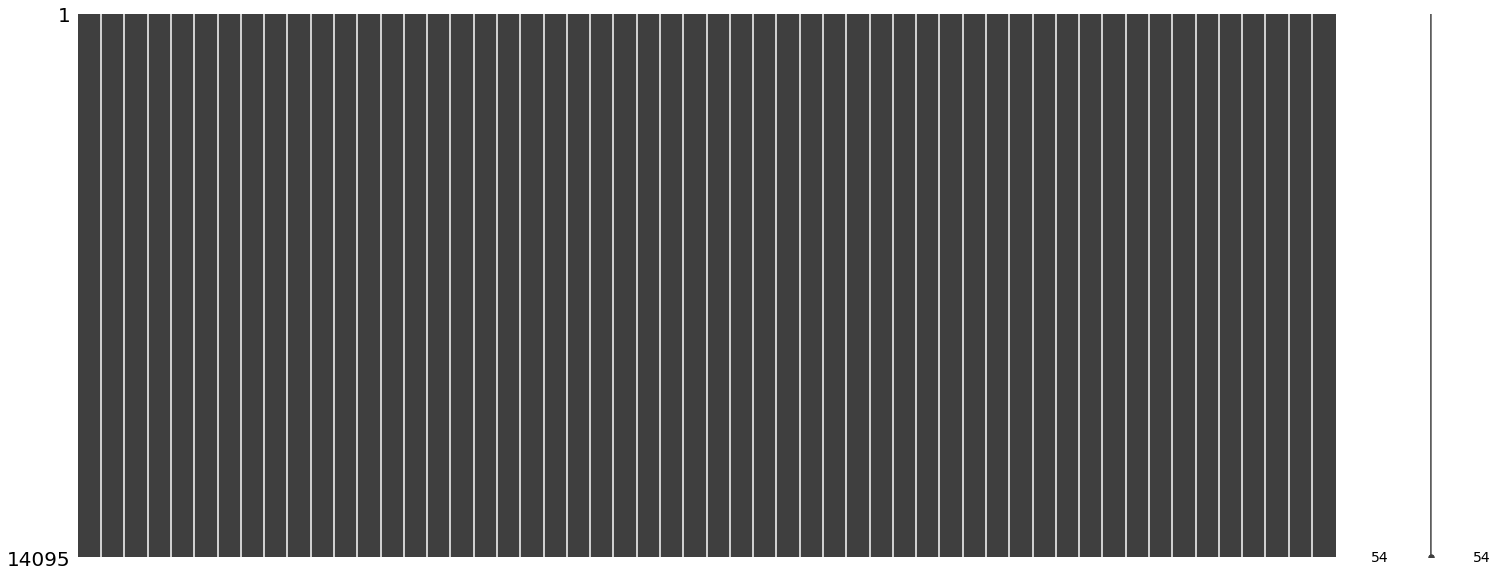

In [4579]:
msno.matrix(train)

### 시각화 검토

In [4580]:
train.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
       'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL'],
      dtype='object')

In [4581]:
numerical_cols = list(set(train.columns.tolist())-set(not_number_features))
print(numerical_cols)
print(len(numerical_cols))

['CR', 'FNOX', 'NI', 'FSO4', 'MG', 'TI', 'ZN', 'U20', 'SN', 'CU', 'MN', 'BE', 'FUEL', 'S', 'CD', 'MO', 'K', 'U4', 'U75', 'AL', 'PB', 'ANONYMOUS_1', 'BA', 'V', 'LI', 'V100', 'FOPTIMETHGLY', 'SI', 'ANONYMOUS_2', 'B', 'CA', 'SAMPLE_TRANSFER_DAY', 'P', 'FH2O', 'SOOTPERCENTAGE', 'U100', 'U50', 'AG', 'NA', 'U6', 'V40', 'CO', 'U25', 'FTBN', 'FE', 'H2O', 'U14', 'PQINDEX', 'FOXID', 'SB']
50


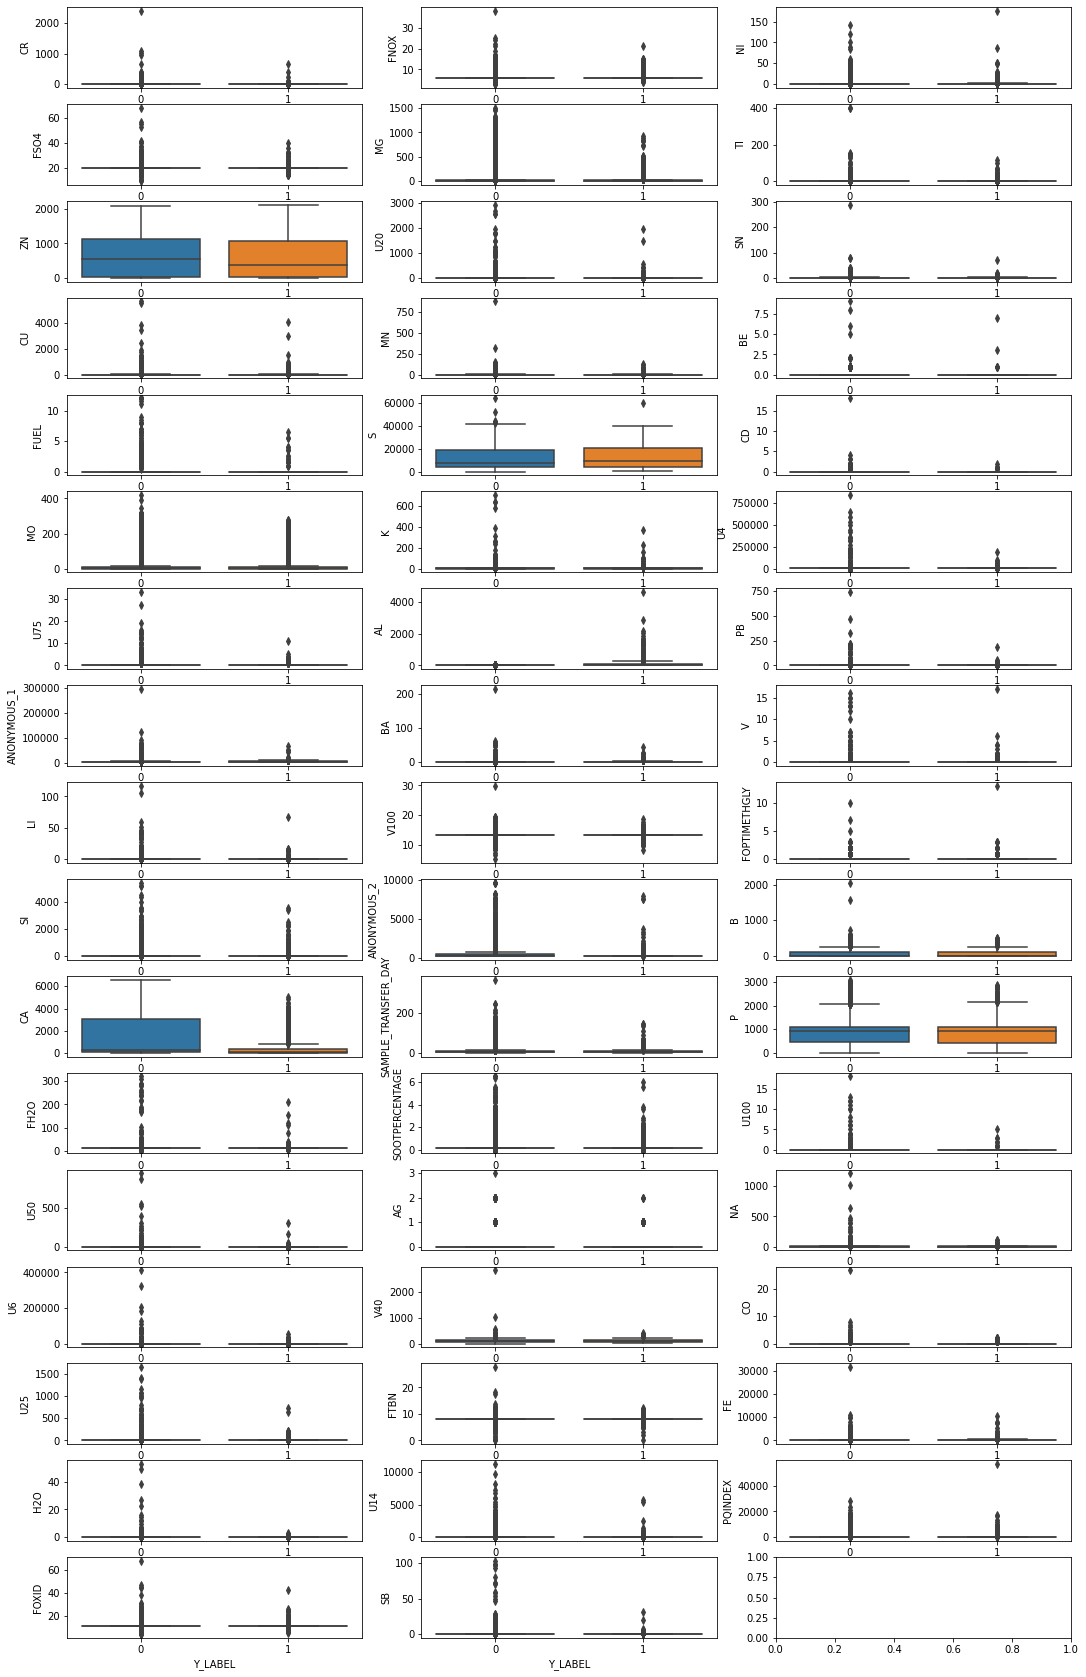

In [4582]:
세로열 = 3
가로열 = int(len(numerical_cols)/세로열+1)

fig, axes = plt.subplots(가로열, 3, figsize=(18, 30))
a = 0
for i, col in enumerate(numerical_cols):
#         print(i%3)
        b=i%3
        sns.boxplot(ax=axes[a, b], data=train, x='Y_LABEL', y=col)
        if b == 2:
            a += 1


In [4583]:
# grid = sns.FacetGrid(data=train, col='YEAR')
# grid.map(sns.stripplot, "Y_LABEL","CA")

In [4584]:
# grid = sns.FacetGrid(data=train, col='Y_LABEL', col_order=[0,1])
# grid.map(sns.scatterplot, "CA", "S")

### Skewness 검토

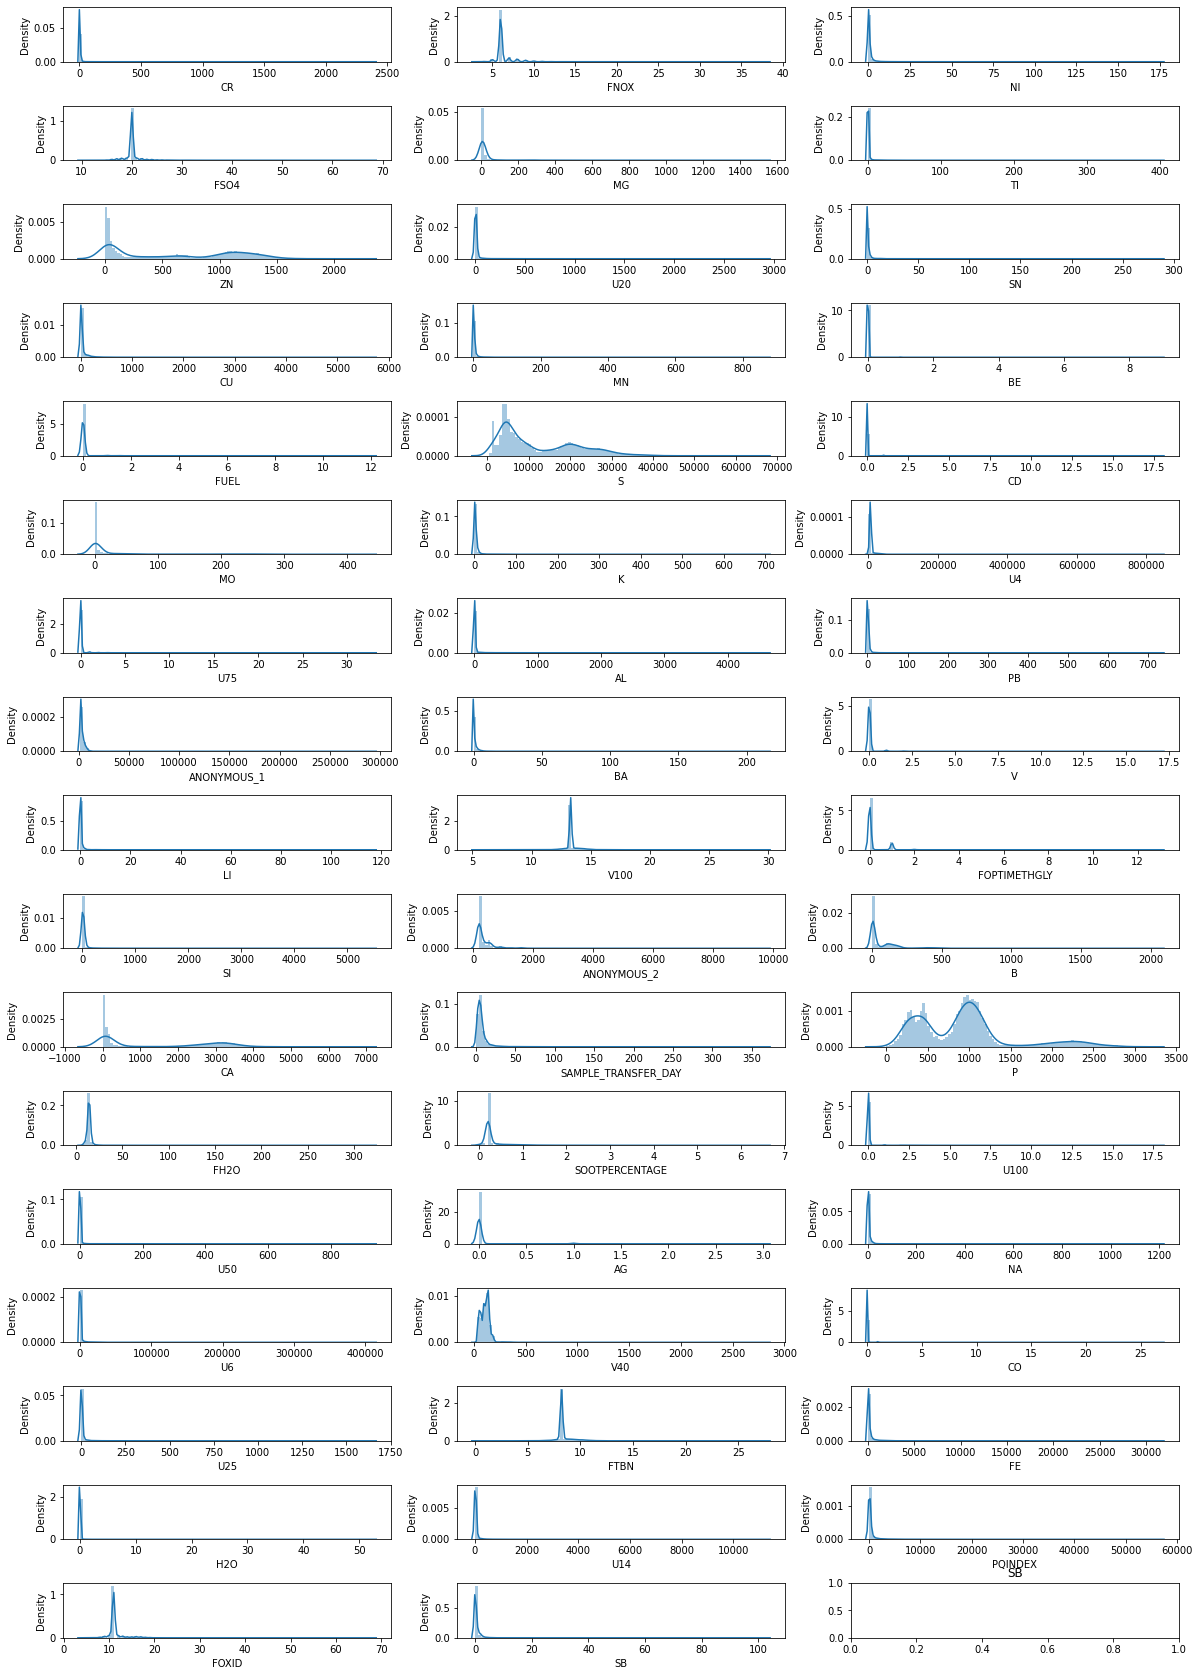

In [4585]:
세로열 = 3
가로열 = int(len(numerical_cols)/세로열+1)

fig, axes = plt.subplots(가로열, 3, figsize=(20, 30))
a = 0
for i, col in enumerate(numerical_cols):
#         print(i%3)
        b=i%3
        sns.distplot(train[col], bins=100, ax=axes[a, b])
        plt.gca().set_title(col)
        plt.subplots_adjust(hspace = 0.8)
        if b == 2:
            a += 1

In [4586]:
skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness

CD                     55.899106
CR                     54.368366
CO                     49.810892
H2O                    48.656666
NA                     43.060333
U50                    41.706142
BE                     40.923712
SN                     39.878475
PB                     39.602904
MN                     38.915313
U6                     36.709851
BA                     34.836012
TI                     34.500761
K                      30.920025
ANONYMOUS_1            30.451948
LI                     28.675390
U4                     28.420830
U100                   26.087449
SB                     25.174375
FH2O                   23.692474
U75                    22.869479
AL                     22.037843
U25                    22.010478
U20                    21.665249
V                      20.985827
CU                     20.741422
NI                     20.387033
FE                     20.119119
U14                    19.628971
FUEL                   14.826516
SI        

In [4587]:
def log_chart(df):
    세로열 = 3
    가로열 = int(len(df.columns)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(20, 30))
    a = 0
    for i, col in enumerate(skew_feats):
        b=i%3
        sns.distplot(df[col], bins=100, ax=axes[a, b])
        plt.gca().set_title(col)
        plt.subplots_adjust(hspace = 0.8)
        if b == 2:
            a += 1

  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------
Index(['CD', 'CR', 'CO', 'H2O', 'NA', 'U50', 'BE', 'SN', 'PB', 'MN', 'U6',
       'BA', 'TI', 'K', 'ANONYMOUS_1', 'LI', 'U4', 'U100', 'SB', 'FH2O', 'U75',
       'AL', 'U25', 'U20', 'V', 'CU', 'NI', 'FE', 'U14', 'FUEL', 'SI', 'V40',
       'SAMPLE_TRANSFER_DAY', 'PQINDEX', 'ANONYMOUS_2', 'AG', 'MG',
       'SOOTPERCENTAGE', 'FOPTIMETHGLY', 'FSO4', 'FOXID', 'FNOX', 'MO', 'B',
       'V100', 'FTBN', 'P'],
      dtype='object')
BE                     23.412466
H2O                    18.578013
CD                     11.885586
U100                   11.430049
CO                      9.008246
FUEL                    8.774924
V                       8.296009
U75                     8.282828
FH2O                    7.129355
AG                      6.600190
LI                      5.496954
U50                     5.171332
TI                      4.836962
U20                     3.716015
U14                     3.641633
U25                     3.458415
SO

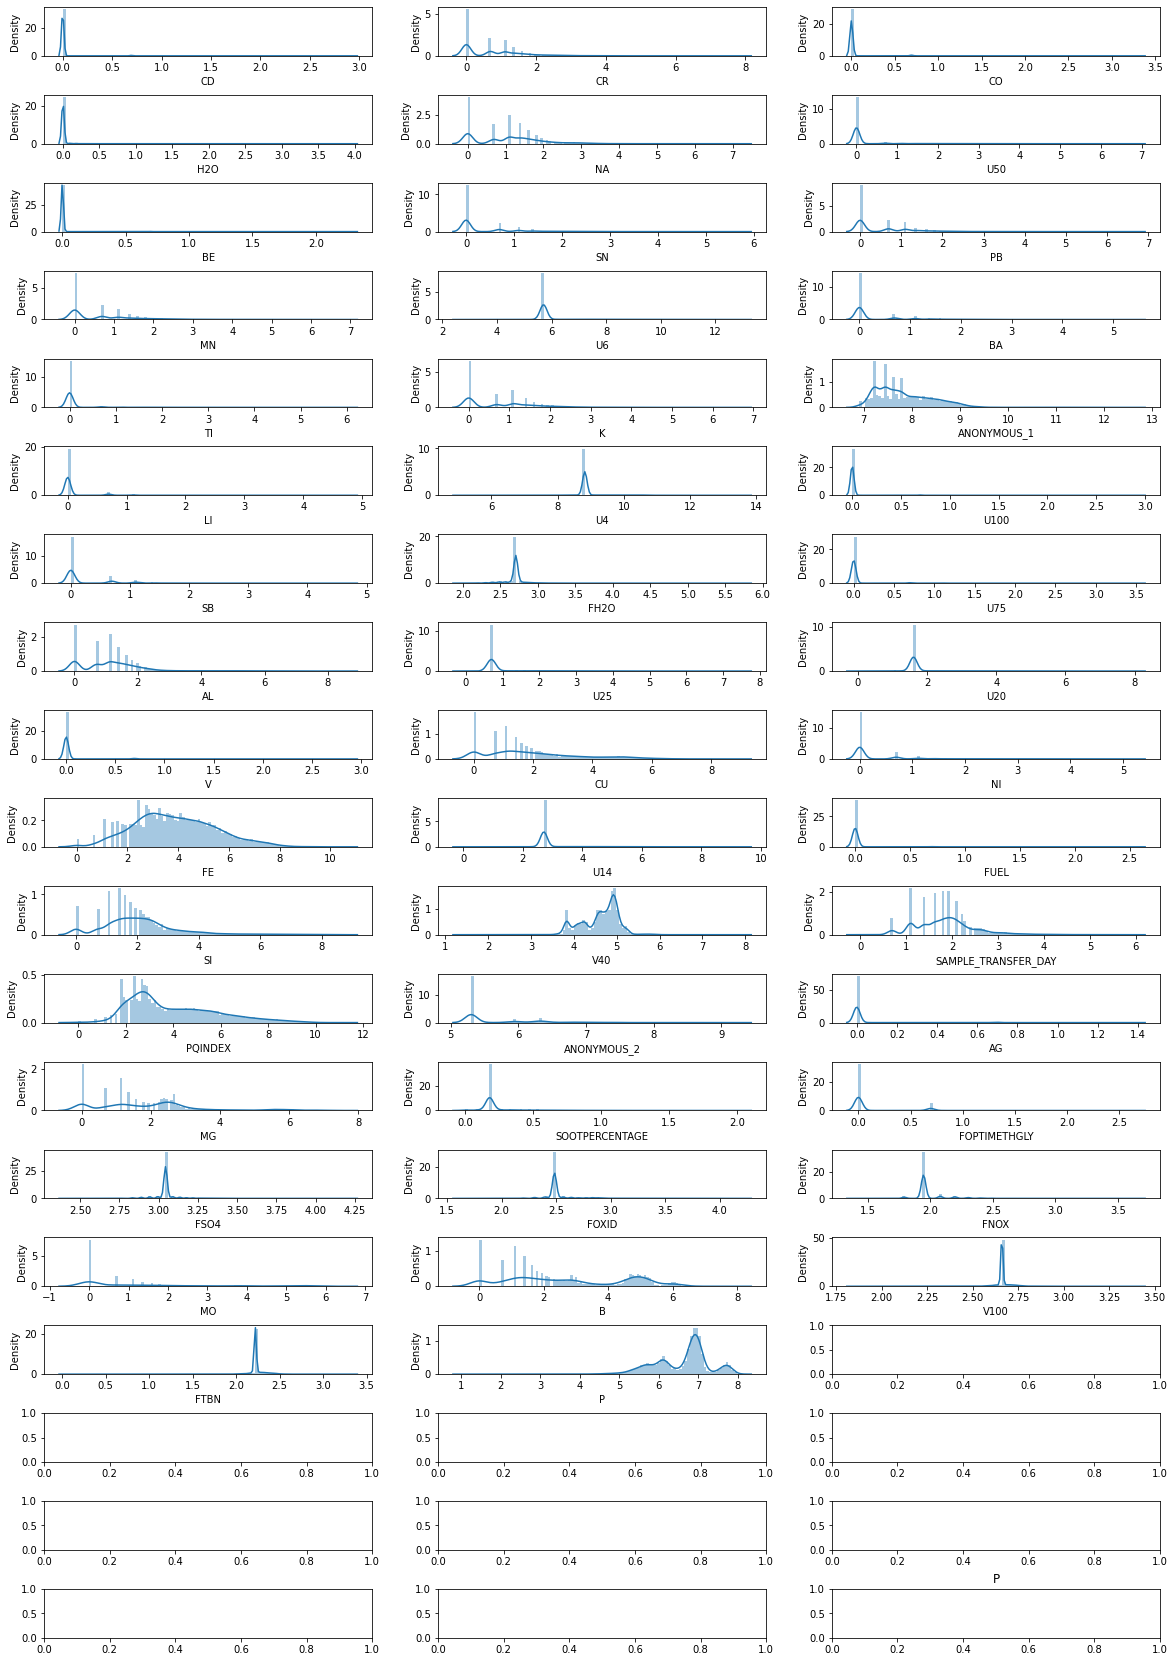

In [4588]:
for i in tqdm(range(CFG['log_turn'])):
    skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    skew_feats = skewness[skewness > CFG['skew_cut']].index
    
    log_train = train[skew_feats].copy()
    log_train[skew_feats] = np.log1p(log_train[skew_feats])
        
    for col in skew_feats:
        train[col] = log_train[col]
    
    skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    print("-"*40)
    print(skew_feats)
    print(skewness)
    
    for col in skew_feats:
        if col in test.columns:
            test[col] = np.log1p(test[col])
        else:
            pass
log_chart(train)



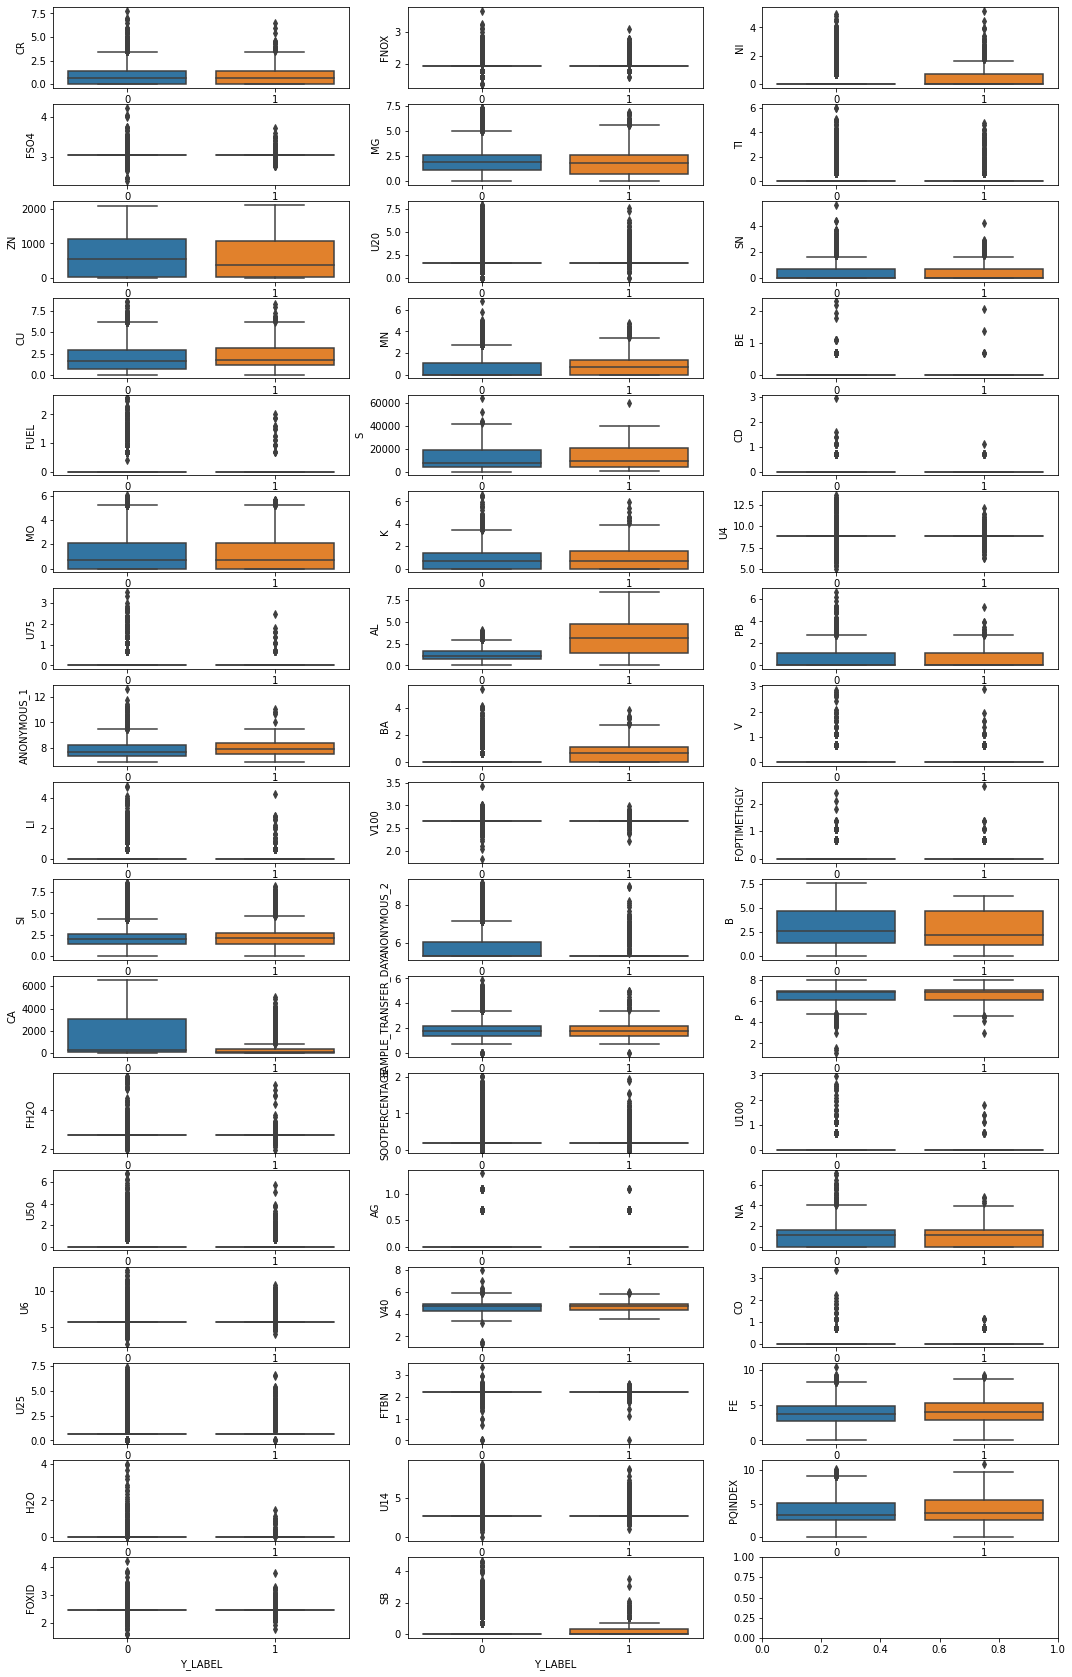

In [4589]:
세로열 = 3
가로열 = int(len(numerical_cols)/세로열+1)

fig, axes = plt.subplots(가로열, 3, figsize=(18, 30))
a = 0
for i, col in enumerate(numerical_cols):
        b=i%3
        sns.boxplot(ax=axes[a, b], data=train, x='Y_LABEL', y=col)
        if b == 2:
            a += 1

### 상관관계 확인(드랍칼럼 선정)

<AxesSubplot:>

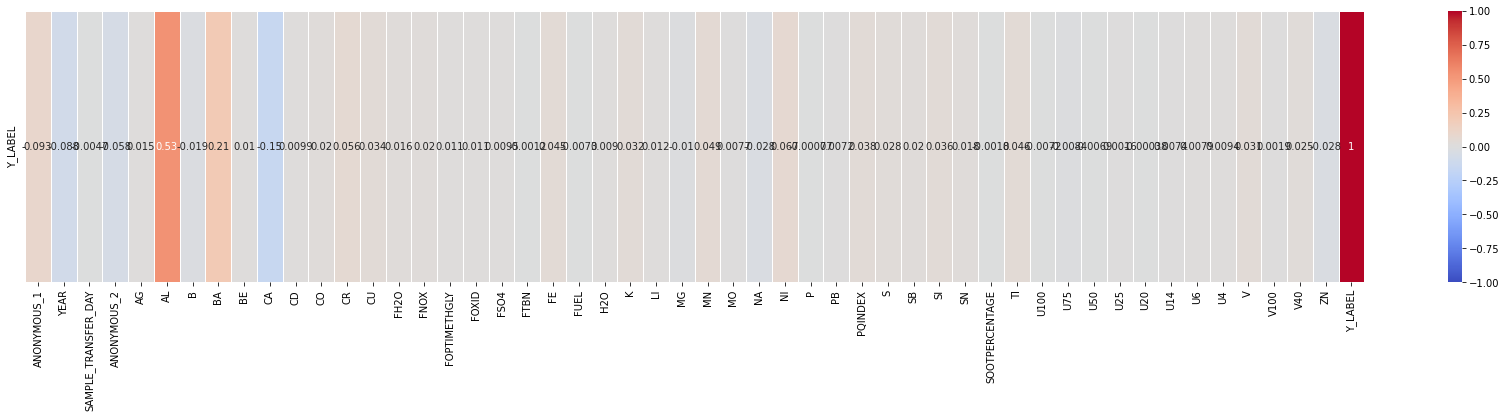

In [4590]:
fig = plt.figure(figsize=(30, 5))
sns.heatmap(train.loc[:,:].corr()[["Y_LABEL"]].T, annot=True, linewidth=1, cmap="coolwarm", vmin=-1, vmax=1)

In [4591]:
df_corr1 = pd.DataFrame(train.corr()["Y_LABEL"].sort_values(ascending=False))
df_corr1

,Y_LABEL
Y_LABEL,1.000000
AL,0.531680
BA,0.205176
ANONYMOUS_1,0.092820
NI,0.067153
CR,0.056019
MN,0.048509
TI,0.046066
FE,0.045108
PQINDEX,0.037558


In [4592]:
# 상관관계가 낮아서 제낄 칼럼들
cutline = CFG['CUT']
# cutline = 0.01
df_corr2 = df_corr1[(df_corr1["Y_LABEL"] < cutline) & (df_corr1["Y_LABEL"] > (cutline*-1))]
print(f"상관관계가 낮아서 드랍할 칼럼 개수 : {len(df_corr2.index)}")
df_corr2.sort_values

상관관계가 낮아서 드랍할 칼럼 개수 : 19


<bound method DataFrame.sort_values of                       Y_LABEL
CD                   0.009921
FSO4                 0.009537
U4                   0.009433
H2O                  0.009037
U6                   0.007905
MO                   0.007714
U14                  0.007442
PB                   0.007244
V100                 0.001948
U25                  0.001557
U20                 -0.000381
P                   -0.000769
FTBN                -0.001173
SOOTPERCENTAGE      -0.001773
SAMPLE_TRANSFER_DAY -0.004679
U50                 -0.006933
U100                -0.007241
FUEL                -0.007314
U75                 -0.008436>

In [4593]:
drop_columns = df_corr2.index.tolist()
# drop_columns

In [4594]:
print(f"드랍하기 전 칼럼 갯수 : {len(train.columns)}")
for col in drop_columns:
    if col in train.columns:
        train.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(f"드랍후 칼럼 갯수 : {len(train.columns)}")

드랍하기 전 칼럼 갯수 : 54
드랍후 칼럼 갯수 : 35


In [4595]:
print(f"드랍하기 전 칼럼 갯수 : {len(test.columns)}")
for col in drop_columns:
    if col in test.columns:
        test.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(f"드랍후 칼럼 갯수 : {len(test.columns)}")

드랍하기 전 칼럼 갯수 : 19
드랍후 칼럼 갯수 : 17


In [4596]:
train.describe()

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CO,...,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN,Y_LABEL
count,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,...,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000
mean,7.838089,2013.652501,5.683069,0.017280,1.227792,2.783313,0.276187,0.003216,1366.757574,0.016475,...,3.962161,12029.318624,0.206442,2.106861,0.340204,0.136156,0.025410,4.620493,588.646825,0.085349
std,0.584597,3.964758,0.608688,0.112395,1.099629,1.829705,0.560102,0.059087,1481.924727,0.119396,...,1.843818,9325.610196,0.450991,1.250317,0.619161,0.515754,0.164464,0.419648,531.743393,0.279411
min,6.908755,2007.000000,5.303305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,386.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.360977,0.000000,0.000000
25%,7.412160,2010.000000,5.303305,0.000000,0.693147,1.386294,0.000000,0.000000,48.000000,0.000000,...,2.564949,4440.500000,0.000000,1.386294,0.000000,0.000000,0.000000,4.287716,37.000000,0.000000
50%,7.708860,2014.000000,5.303305,0.000000,1.098612,2.484907,0.000000,0.000000,198.000000,0.000000,...,3.401197,8034.000000,0.000000,1.945910,0.000000,0.000000,0.000000,4.721174,520.000000,0.000000
75%,8.242230,2017.000000,6.018593,0.000000,1.609438,4.709530,0.000000,0.000000,2975.000000,0.000000,...,5.204007,19750.000000,0.000000,2.564949,0.693147,0.000000,0.000000,4.928702,1119.000000,0.000000
max,12.592871,2022.000000,9.174817,1.386294,8.440528,7.626570,5.379897,2.302585,6609.000000,3.332205,...,10.946622,64160.000000,4.644391,8.605204,5.669881,6.001415,2.890372,7.952087,2132.000000,1.000000


### 수치형 데이터 이상치 처리

In [4597]:
not_number_features = ['ID','COMPONENT_ARBITRARY', 'YEAR', "Y_LABEL"]

In [4598]:
train.drop(columns = "ID", axis = 1, inplace = True)
test.drop(columns = "ID", axis = 1, inplace = True)

In [4599]:
# #이상치 인덱스 확인 함수
# def get_outlier(df=None, col=None, weight=1.5):
#     target = df[col]
#     quantile_25 = np.quantile(target, 0.25)
#     quantile_75 = np.quantile(target, 0.75)
#     iqr = quantile_75 - quantile_25
#     iqr_weight = iqr * weight
#     lowest_val = quantile_25 - iqr_weight
#     highest_val = quantile_75 + iqr_weight
#     outlier_index = target[(target < lowest_val) | (target > highest_val)].index
#     return outlier_index
    

In [4600]:
# get_outlier(test, "CO")

In [4601]:
# 이상치칼럼 = []
# for target1 in train.columns:
# #     print(target1)
#     huddle = 0.3  # 허들이상의 상관관계를 가진 칼럼에 대해서만 이상치 드랍
    
#     if target1 not in not_number_features and ((df_corr1.loc[[target1]].values[0][0] >= huddle) or (df_corr1.loc[[target1]].values[0][0] <= (huddle*-1))):
#         print(target1)
#         이상치칼럼.append(target1)
        
#         outlier_index = get_outlier(train, target1)
#         print(f"드랍대상 아웃라이어 인덱스 갯수 : {len(outlier_index)}")
        
#         train.drop(index=outlier_index, inplace=True)

#     else:
#         pass
    
# print(이상치칼럼)

In [4602]:
# train.describe()

In [4603]:
# test.describe()

In [4604]:
# if target1 in 이상치칼럼 :
#     print(target1)
#     outlier_index2 = get_outlier(test, target1)
#     print(f"드랍대상 아웃라이어 인덱스 갯수 : {len(outlier_index2)}")

#     test.drop(index=outlier_index, inplace=True)
# else:
#     pass

### train, val 데이터셋 분리

In [4605]:
all_X = train.drop(['Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']
# test = test.drop(['ID'], axis = 1)
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [4606]:
train_X.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,NI,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN
6216,COMPONENT3,8.153925,2016,5.303305,0.0,1.609438,4.700480,0.0,0.0,3133,...,0.0,6.614726,34000,0.0,2.639057,0.0,0.0,0.0,4.965638,20
13544,COMPONENT3,8.657651,2014,5.303305,0.0,0.000000,3.044522,0.0,0.0,188,...,0.0,7.270313,19430,0.0,1.791759,0.0,0.0,0.0,4.799914,24


In [4607]:
val_X.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,NI,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN
13107,COMPONENT3,7.643004,2012,5.303305,0.0,0.693147,3.135494,0.0,0.0,14,...,0.0,4.744932,28210,0.0,2.079442,0.0,0.0,0.0,4.995183,45
731,COMPONENT3,7.276556,2018,5.929589,0.0,1.386294,0.000000,0.0,0.0,3471,...,0.0,5.505332,18650,0.0,1.098612,0.0,0.0,0.0,4.916325,51


### Scaling

In [4608]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']

<AxesSubplot:>

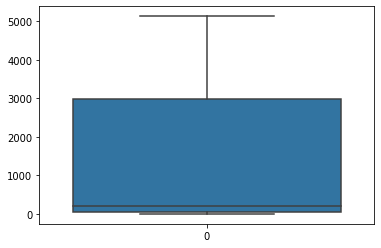

In [4609]:
sns.boxplot(data=train_X['CA'])

In [4610]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:   # 범주형 칼럼이 아니라면 표준화
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
train_X.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,NI,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN
6216,COMPONENT3,0.530394,2016,-0.623912,-0.153432,0.351080,1.044835,-0.492425,-0.054682,1.184617,...,-0.440887,1.446119,2.350677,-0.461166,0.425958,-0.551161,-0.26383,-0.152986,0.817716,-1.069154
13544,COMPONENT3,1.387489,2014,-0.623912,-0.153432,-1.126685,0.140664,-0.492425,-0.054682,-0.797281,...,-0.440887,1.802426,0.791533,-0.461166,-0.252085,-0.551161,-0.26383,-0.152986,0.423663,-1.061642


In [4611]:
# target = "AL"
# 정상 = train_X[train_X["Y_LABEL"] == 0][target]
# 이상= train_X[train_X["Y_LABEL"] == 1][target]
# 정상 = pd.DataFrame(정상)
# plt.figure(figsize = (12,6))
# sns.distplot(정상,bins = 15, color="red")
# sns.distplot(이상,bins = 15, color="green")

<AxesSubplot:>

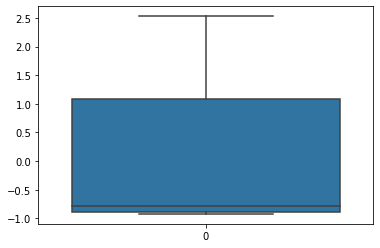

In [4612]:
sns.boxplot(data=train_X['CA'])

### OneHotEncoding for Categorical Data

In [4613]:
def onehot_encode(df, target_list):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [0, 2])], remainder='passthrough')
    df = ct.fit_transform(df)
    df = pd.DataFrame(df)
    new_name = ct.get_feature_names()
    df.columns = new_name
    return df

In [4614]:
train_X = onehot_encode(train_X, [0,2])
train_X

,encoder__x0_COMPONENT2,encoder__x0_COMPONENT3,encoder__x0_COMPONENT4,encoder__x1_2008,encoder__x1_2009,encoder__x1_2010,encoder__x1_2011,encoder__x1_2012,encoder__x1_2013,encoder__x1_2014,...,NI,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.440887,1.446119,2.350677,-0.461166,0.425958,-0.551161,-0.26383,-0.152986,0.817716,-1.069154
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.440887,1.802426,0.791533,-0.461166,-0.252085,-0.551161,-0.26383,-0.152986,0.423663,-1.061642
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.440887,-1.018774,-0.968471,1.987228,-0.576555,-0.551161,-0.26383,-0.152986,-0.060891,1.055072
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.914477,1.329558,-0.889818,-0.461166,-0.252085,-0.551161,-0.26383,-0.152986,0.327820,-0.261535
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.440887,-1.772215,-0.546207,-0.461166,0.072385,0.578497,-0.26383,-0.152986,0.460558,1.083244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11271,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.440887,0.840958,1.729695,1.083599,-0.021870,2.620189,-0.26383,-0.152986,0.873435,-0.868189
11272,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.440887,1.506723,0.381682,-0.461166,0.670337,-0.551161,-0.26383,-0.152986,0.633327,-1.027834
11273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.440887,-0.468977,-0.061342,-0.461166,-0.576555,0.578497,-0.26383,-0.152986,-0.386983,1.090757
11274,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.440887,0.822915,0.002864,-0.461166,0.750428,-0.551161,-0.26383,-0.152986,0.904012,-1.080423


In [4615]:
val_X = onehot_encode(val_X, [0,2])
val_X

,encoder__x0_COMPONENT2,encoder__x0_COMPONENT3,encoder__x0_COMPONENT4,encoder__x1_2008,encoder__x1_2009,encoder__x1_2010,encoder__x1_2011,encoder__x1_2012,encoder__x1_2013,encoder__x1_2014,...,NI,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.440887,0.429900,1.731086,-0.461166,-0.021870,-0.551161,-0.263830,-0.152986,0.887968,-1.022200
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.440887,0.843172,0.708064,-0.461166,-0.806770,-0.551161,-0.263830,-0.152986,0.700460,-1.010931
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.440887,-1.018774,-0.826040,-0.461166,-0.128727,-0.551161,-0.263830,-0.152986,0.333925,1.124564
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.440887,-0.548654,-0.809025,-0.461166,0.627070,1.708155,-0.263830,-0.152986,-0.373262,1.064463
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.440887,-1.551848,-0.840807,-0.461166,1.181755,1.708155,-0.263830,-0.152986,0.384197,1.115173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2814,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.808334,0.891749,0.823208,1.083599,0.532815,0.578497,1.086823,-0.152986,0.747034,-0.817478
2815,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.440887,1.365367,2.057468,-0.461166,0.366654,-0.551161,-0.263830,-0.152986,0.834240,-1.061642
2816,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.440887,1.419238,1.160719,-0.461166,0.072385,-0.551161,-0.263830,-0.152986,0.636908,-1.059763
2817,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.440887,-0.494260,-0.558727,-0.461166,-0.252085,-0.551161,-0.263830,-0.152986,-0.959911,1.009995


In [4616]:
test = onehot_encode(test, [0,2])
test

,encoder__x0_COMPONENT2,encoder__x0_COMPONENT3,encoder__x0_COMPONENT4,encoder__x1_2008,encoder__x1_2009,encoder__x1_2010,encoder__x1_2011,encoder__x1_2012,encoder__x1_2013,encoder__x1_2014,...,CR,CU,FE,MN,NI,PQINDEX,TI,V,V40,ZN
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.886649,-0.829839,-0.832563,-0.784966,-0.440887,-0.845697,-0.263830,-0.152986,-0.229915,0.942381
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.374450,-0.829839,1.126054,0.766409,-0.440887,2.151806,1.086823,-0.152986,0.545725,-1.084180
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.886649,0.511930,-1.326448,-0.784966,-0.440887,-0.798407,-0.263830,-0.152986,-1.922264,0.234305
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.704681,-0.255347,0.786650,1.016124,-0.440887,2.736083,-0.263830,-0.152986,0.824339,-0.930169
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.886649,-0.044387,-0.785225,-0.784966,-0.440887,-0.609105,-0.263830,-0.152986,-1.085748,-0.225850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.704681,1.792204,1.971412,3.903594,1.539081,1.982099,-0.263830,-0.152986,-0.813906,1.077610
6037,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.170115,-0.575622,1.746534,1.220157,-0.440887,1.406850,-0.263830,-0.152986,0.740191,-1.082302
6038,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.886649,-1.264426,0.077059,-0.784966,-0.440887,0.160091,-0.263830,-0.152986,2.598084,-1.082302
6039,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.886649,1.333219,-1.769206,-0.784966,-0.440887,-1.175127,-0.263830,-0.152986,-1.589714,-0.208946


In [4617]:
test_stage_features = test.columns
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features

Index(['encoder__x0_COMPONENT2', 'encoder__x0_COMPONENT3',
       'encoder__x0_COMPONENT4', 'encoder__x1_2008', 'encoder__x1_2009',
       'encoder__x1_2010', 'encoder__x1_2011', 'encoder__x1_2012',
       'encoder__x1_2013', 'encoder__x1_2014', 'encoder__x1_2015',
       'encoder__x1_2016', 'encoder__x1_2017', 'encoder__x1_2018',
       'encoder__x1_2019', 'encoder__x1_2020', 'encoder__x1_2021',
       'encoder__x1_2022', 'ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'CO', 'CR',
       'CU', 'FE', 'MN', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN'],
      dtype='object')

In [4618]:
train_col_num = len(train_X.columns)
test_col_num = len(test.columns)
print(train_col_num, test_col_num) # Drop후 칼럼 갯수 (nn 시작 노드 갯수에 맞춰주기 위해 변수에 담아놓음)

49 32


In [4619]:
import pickle

#저장하기
with open(f"./data/refined_train_X{file_version}", 'wb') as pickle_filename:
	pickle.dump(train_X, pickle_filename)

with open(f"./data/refined_train_y{file_version}", 'wb') as pickle_filename:
	pickle.dump(train_y, pickle_filename)
    
with open(f"./data/refined_val_X{file_version}", 'wb') as pickle_filename:
	pickle.dump(val_X, pickle_filename)

with open(f"./data/refined_val_y{file_version}", 'wb') as pickle_filename:
	pickle.dump(val_y, pickle_filename)
    
with open(f"./data/refined_test{file_version}", 'wb') as pickle_filename:
	pickle.dump(test, pickle_filename)

In [4620]:
#불러오기
with open(f"./data/refined_train_X{file_version}", 'rb') as pickle_filename:
	train_X = pickle.load(pickle_filename)

with open(f"./data/refined_train_y{file_version}", 'rb') as pickle_filename:
	train_y = pickle.load(pickle_filename)
    
with open(f"./data/refined_val_X{file_version}", 'rb') as pickle_filename:
	val_X = pickle.load(pickle_filename)

with open(f"./data/refined_val_y{file_version}", 'rb') as pickle_filename:
	val_y = pickle.load(pickle_filename)     

with open(f"./data/refined_test{file_version}", 'rb') as pickle_filename:
	test = pickle.load(pickle_filename)

In [4621]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [4622]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)
list(train_dataset)[:1]

[(tensor([ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.5304, -0.6239, -0.1534,  0.3511,  1.0448, -0.4924,
          -0.0547,  1.1846, -0.1379,  0.7047, -0.3953,  0.0352, -0.2906, -0.3919,
          -0.1892,  0.5709, -0.1436, -0.2568, -1.3068,  0.7664,  1.5908, -0.4409,
           1.4461,  2.3507, -0.4612,  0.4260, -0.5512, -0.2638, -0.1530,  0.8177,
          -1.0692]),
  0)]

In [4623]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)
list(train_loader)[:1] 

[[tensor([[ 0.0000,  0.0000,  1.0000,  ..., -0.1530, -0.8807,  0.4033],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.1530,  0.2659,  1.5040],
          [ 0.0000,  0.0000,  1.0000,  ..., -0.1530, -0.7682,  1.1039],
          ...,
          [ 1.0000,  0.0000,  0.0000,  ..., -0.1530, -1.8806,  0.2287],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.1530, -0.3218,  0.8973],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.1530, -0.2402,  1.0025]]),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
          0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0

In [4624]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=train_col_num, out_features=256),
            nn.Dropout(p=CFG['drop_rate']),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1024),
            nn.Dropout(p=CFG['drop_rate']),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.Dropout(p=CFG['drop_rate']),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

#### BCELOSS : https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

In [4625]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    
    # Loss Function 정의
    criterion = nn.BCELoss(reduction = CFG['reduct']).to(device)  #BCEWithLogitsLoss
#     criterion = nn.BCEWithLogitsLoss(reduction = CFG['reduct']).to(device)  #BCEWithLogitsLoss

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y.reshape(-1, 1))  # loss_fn(input, target)
            loss.backward()
            
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
        
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
    print(f"Teacher Train Best Score는 {best_score} 입니다.")
    return best_model 

In [4626]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = CFG['T_Thresh']     
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  # squeeze함수는 차원이 1인 차원을 제거해준다.
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        #print(pred_labels[0:10])
        # 오일상태는 0: 정상, 1: 이상
        # 어느 임계점 thrshold보다 큰 예측 라벨을 1로 하고, 나머지를 0으로 할 것인가?
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        #print(pred_labels[0:10])
        
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1   

#### 옵티마이저 (Optimizer)

+ 손실 함수를 기반으로 모델이 어떻게 업데이트해야하는지를 결정 

+ optimizer는 step()을 통해 전달받은 파라미터를 모델 업데이트

+ 모든 옵티마이저는 기본으로 torch.optim.Optimzer(params, defaults) 클래스를 사용

+ zero_grad()를 이용해 옵티마이저에 사용된 파라미터의 기울기를 0으로 설정

+ torch.optim.lr_scheduler를 이용해 epoch에 따라 학습률 조절

+ 파이토치 주요 옵티마이저: optim.Adadelta, optim.Adagrad, optim.Adam , optim.RMSprop, optim.SGD

* TORCH.OPTIM : https://pytorch.org/docs/stable/optim.html


#### 학습률 스케줄러 (Learning rate scheduler)

+ 학습시 특성 조건에 따라 학습률을 조정하여 최적화 진행

+ 일정 횟수 이상이 되면 학습률을 감소시키거나, 전역 최소점 근처에가 하면 학습률을 줄이는 등  

+ optim.lr_scheduler.LamdbaLR : 람다 함수를 이용해 그 결과를 학습률로 설정

+ optim.lr_scheduler.StepLR : 단계 마다 학습률을 감마 비율로 감소

+ optim.lr_scheduler.MultiStepLR : StepLR과 비슷하지만 지정된 에포카에서만 감마 비율로 감소

+ optim.lr_scheduler.ExponentialLR : epoch마다 이전 학습률에 감마만큼 곱함

+ optim.lr_scheduler.CosineAnnealingLR : 학습률을 코사인 함수의 형태로 변화시켜 학습률을 조절

+ optim.lr_scheduler.ReduceLROnPlateau : 학습이 잘 되는지 아닌지에 따라 동적으로 학습률 변화 
+ 링크 : https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html?highlight=reducelronplateau#torch.optim.lr_scheduler.ReduceLROnPlateau
* 인자설명 : https://deep-deep-deep.tistory.com/56

In [4627]:
model = Teacher()
model.eval()
print("-"*30)
# print(list(model.parameters()))   # check out the parameters
print("-"*30)
# print(model.state_dict())   # list the named parameters
print("-"*30)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

------------------------------
------------------------------
------------------------------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.44457] Val Loss : [0.18056] Val F1 Score : [0.73803]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.20684] Val Loss : [0.16944] Val F1 Score : [0.81725]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.17778] Val Loss : [0.15732] Val F1 Score : [0.82115]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.17091] Val Loss : [0.15313] Val F1 Score : [0.82492]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.18661] Val Loss : [0.19144] Val F1 Score : [0.81952]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.18383] Val Loss : [0.16530] Val F1 Score : [0.81990]
Epoch 00006: reducing learning rate of group 0 to 5.0000e-02.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.16248] Val Loss : [0.14971] Val F1 Score : [0.82346]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.15391] Val Loss : [0.14735] Val F1 Score : [0.83002]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.15258] Val Loss : [0.14377] Val F1 Score : [0.83332]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.15354] Val Loss : [0.14730] Val F1 Score : [0.82332]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.15330] Val Loss : [0.14156] Val F1 Score : [0.82234]
Epoch 00011: reducing learning rate of group 0 to 2.5000e-02.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.14649] Val Loss : [0.14063] Val F1 Score : [0.82887]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.15645] Val Loss : [0.14176] Val F1 Score : [0.83682]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.15082] Val Loss : [0.14122] Val F1 Score : [0.83393]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.15044] Val Loss : [0.14659] Val F1 Score : [0.82873]
Epoch 00015: reducing learning rate of group 0 to 1.2500e-02.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.18221] Val Loss : [0.14906] Val F1 Score : [0.83661]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.14846] Val Loss : [0.14530] Val F1 Score : [0.82492]
Epoch 00017: reducing learning rate of group 0 to 6.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.13799] Val Loss : [0.14561] Val F1 Score : [0.82234]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.13659] Val Loss : [0.14434] Val F1 Score : [0.82419]
Epoch 00019: reducing learning rate of group 0 to 3.1250e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.14165] Val Loss : [0.14648] Val F1 Score : [0.82871]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.13525] Val Loss : [0.14303] Val F1 Score : [0.82321]
Epoch 00021: reducing learning rate of group 0 to 1.5625e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.13310] Val Loss : [0.14649] Val F1 Score : [0.83035]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.13444] Val Loss : [0.14599] Val F1 Score : [0.82954]
Epoch 00023: reducing learning rate of group 0 to 7.8125e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.13189] Val Loss : [0.14736] Val F1 Score : [0.83374]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.13797] Val Loss : [0.14758] Val F1 Score : [0.83197]
Epoch 00025: reducing learning rate of group 0 to 3.9063e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.13112] Val Loss : [0.14634] Val F1 Score : [0.82419]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.13055] Val Loss : [0.14722] Val F1 Score : [0.82604]
Epoch 00027: reducing learning rate of group 0 to 1.9531e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.13118] Val Loss : [0.14894] Val F1 Score : [0.83452]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.14415] Val Loss : [0.14764] Val F1 Score : [0.83295]
Epoch 00029: reducing learning rate of group 0 to 9.7656e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.13249] Val Loss : [0.14666] Val F1 Score : [0.83233]
Teacher Train Best Score는 0.8368229219737644 입니다.


In [4628]:
PATH = f"./models/teacher_net{file_version}.pth"
torch.save(teacher_model.state_dict(), PATH)

In [4629]:
teacher_model = Teacher()
teacher_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [4630]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=test_col_num, out_features=128),
            nn.Dropout(p=CFG['drop_rate']),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.Dropout(p=CFG['drop_rate']),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.Dropout(p=CFG['drop_rate']),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [4631]:
# # distillation Function 정의

# def distillation(student_logits, labels, teacher_logits, alpha):
    
#     student_loss = nn.BCELoss(reduction = CFG['reduct'])(student_logits, labels.reshape(-1, 1))
#     distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    
#     return alpha * student_loss + (1-alpha) * distillation_loss

# def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
#     loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

#     if opt is not None:
#         opt.zero_grad()
#         loss_b.backward()
#         opt.step()

#     return loss_b.item()

In [4632]:
# distillation Function 정의

def distillation(student_logits, labels, teacher_logits, alpha, T):
    
    student_loss = nn.BCELoss(reduction = CFG['reduct'])(student_logits, labels.reshape(-1, 1)) #BCEWithLogitsLoss
#     student_loss = nn.BCEWithLogitsLoss(reduction = CFG['reduct'])(student_logits, labels.reshape(-1, 1)) #BCEWithLogitsLoss

    distillation_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(student_logits/T, dim=1), F.softmax(teacher_logits/T, dim=1)) * (T * T)
    
    return alpha * student_loss + (1-alpha) * distillation_loss

def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1, T=10)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

In [4633]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)
    
    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        t_model.eval()    # teather는 이번에는 학습하지 않으므로 .eval()로 불러온다
        
        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)
                
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
    
    print(f"Student Train Best Score는 {best_score} 입니다.")
        
    return best_model

In [4634]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = CFG['S_Thresh']
    
    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1    

In [4635]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [4636]:
student_model = Student()
student_model.eval()
optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

best_student_model = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.03433] Val Loss : [0.02679] Val F1 Score : [0.47767]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.02955] Val Loss : [0.02574] Val F1 Score : [0.47767]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.02911] Val Loss : [0.02588] Val F1 Score : [0.47758]
Epoch 00003: reducing learning rate of group 0 to 5.0000e-02.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.02759] Val Loss : [0.02560] Val F1 Score : [0.47767]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.02771] Val Loss : [0.02571] Val F1 Score : [0.47767]
Epoch 00005: reducing learning rate of group 0 to 2.5000e-02.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.02710] Val Loss : [0.02559] Val F1 Score : [0.47758]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.02741] Val Loss : [0.02525] Val F1 Score : [0.47767]
Epoch 00007: reducing learning rate of group 0 to 1.2500e-02.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.02835] Val Loss : [0.02524] Val F1 Score : [0.47767]


  0%|          | 0/45 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
PATH1 = f"./models/student_net{file_version}.pth"
torch.save(best_student_model.state_dict(), PATH1)

In [ ]:
best_student_model = Student()
best_student_model.load_state_dict(torch.load(PATH1))

In [ ]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
#     thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [ ]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
choose_threshold_result = f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]'
print(choose_threshold_result)

In [ ]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    # .eval함수는 evaluation 과정에서 사용하지 말아야 하는 layer들을 알아서 off 시키는 함수
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)  
    # threshhold 보다 큰 값을 찾아서 1로 바꾸고, 아닌 것은 0으로 변경해라
    print('Done.')
    return test_predict

In [ ]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

In [ ]:
pred_cnt = tuple(submit["Y_LABEL"].value_counts())
a, b = pred_cnt
r = f"정상값 개수 : {a}, 이상값 개수 : {b}"
print(r)

In [ ]:
submit.to_csv(f'./submits/submit{file_version}.csv', index=False)

In [ ]:
record = {"ver": file_version, "CFG": CFG, "Val_result": choose_threshold_result, "pred_cnt": r}
record